In [338]:
# Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

# Titanic Competition

0. Loading in the data
1. EDA
2. Preprocessing and Feature Engineering
3. Modeling
4. Final Model Diagnostics and Predictions

## 0: Loading in the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## 1. EDA

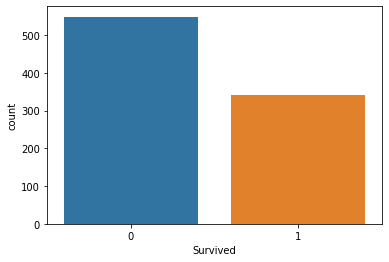

In [5]:
# Some class imbalance, but not extreme
sns.countplot(x='Survived', data=train);

### 1.2 Categorical Features

Relationship between categorical features and the binary response variable

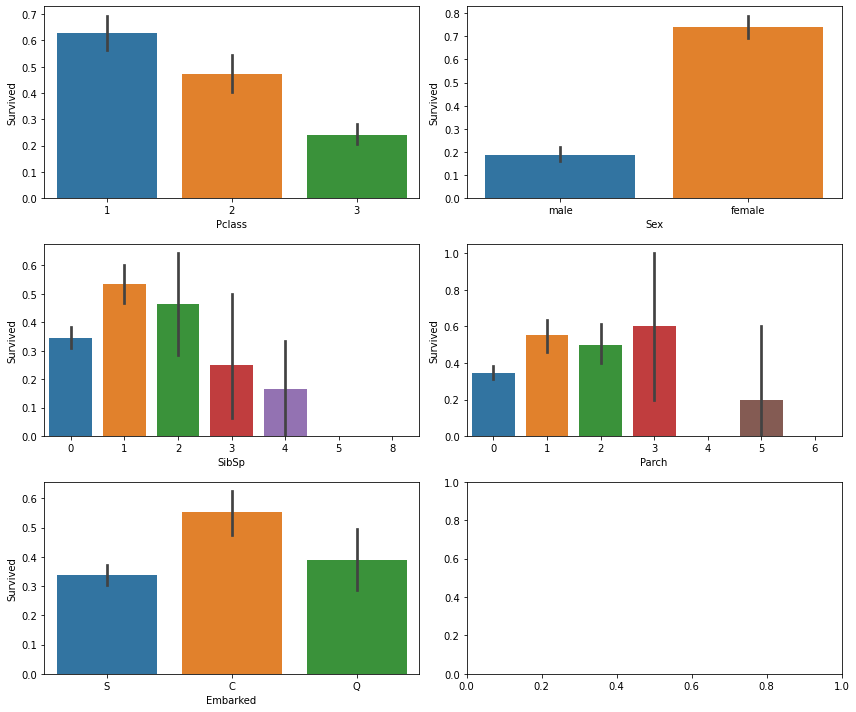

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False)
sns.barplot(x='Pclass', y='Survived', data=train, ax=ax[0, 0]);
sns.barplot(x='Sex', y='Survived', data=train, ax=ax[0, 1]);
sns.barplot(x='SibSp', y='Survived', data=train, ax=ax[1, 0]);
sns.barplot(x='Parch', y='Survived', data=train, ax=ax[1, 1]);
sns.barplot(x='Embarked', y='Survived', data=train, ax=ax[2, 0]);
fig.tight_layout()

1. Higher classes more likely to survive
2. Females much more likely to survive
3. Passengers with 1 or 2 siblings or spouses more likely to survive
4. Passengers with 1 2 or 3 parents or children more likely to survive
5. Passengers from Cherbourg more likely to survive

In [7]:
# Repeat tickets for same family
print(len(train['Ticket'].unique()))
train['Ticket'].value_counts()

681


347082              7
CA. 2343            7
1601                7
347088              6
CA 2144             6
                   ..
PC 17318            1
36967               1
SOTON/O2 3101272    1
237789              1
28134               1
Name: Ticket, Length: 681, dtype: int64

In [8]:
# First letter may give an indication of survival?
print(len(train['Cabin'].unique()))
train['Cabin'].unique()[:10]

148


array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78'], dtype=object)

### 1.2 Continuous Features

Relationship between continuous features and the binary response variable

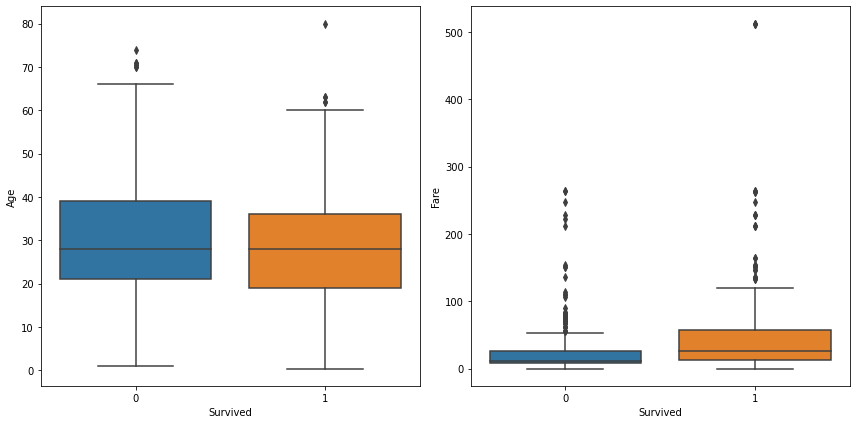

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=False)
sns.boxplot(x='Survived', y='Age', data=train, ax=ax[0]);
sns.boxplot(x='Survived', y='Fare', data=train, ax=ax[1]);
plt.tight_layout();

1. Not much differentiation, but appears that non-survivors were slightly older
2. A good amount of outliers, but survivors had a higher fare

### 1.3 Name

In [10]:
train['Name'].unique()[:20]

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima'], dtype=object)

## 2. Preproccessing and Feature Engineering

### 2.1 Replacing Missing Data

In [11]:
def replace_age(df):
    """
    Replace missing ages with the Median amongst all passengers with the same title
    - if subdf is empty, then replace with overall Median
    """
    replaced = df.copy()
    
    replaced['Title'] = replaced['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    for i in np.arange(len(replaced)):
        age = replaced.loc[i, 'Age']
        if pd.isnull(age):
            title = replaced.loc[i, 'Title']
            sub_df = replaced[replaced['Title'] == title]
            if sum(~sub_df['Age'].isna()) == 0:
                replaced.loc[i, 'Age'] = np.nanmedian(replaced['Age'])
            else:
                replaced.loc[i, 'Age'] = np.nanmedian(sub_df['Age'])
    replaced = replaced.drop(['Title'], axis=1)
    
    return replaced

In [12]:
def replace_fare(df):
    """
    Replace missing fare with the Median amongst all passengers from the same class
    """
    replaced = df.copy()

    for i in np.arange(len(replaced)):
        fare = replaced.loc[i, 'Fare']
        if pd.isnull(fare):
            pclass = replaced.loc[i, 'Pclass']
            sub_df = replaced[replaced['Pclass'] == pclass]
            replaced.loc[i, 'Fare'] = np.nanmedian(sub_df['Fare'])

    return replaced

### 2.2 New Features

- Title
- Cabin Encoding
- Alone

TO ADD
- Age, Fair categories using Cut

In [14]:
train_titles = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Mme           1
Don           1
Lady          1
Sir           1
Ms            1
Capt          1
Countess      1
Jonkheer      1
Name: Name, dtype: int64

In [281]:
# Noticed several titles in name column
def add_title(df):
    """
    Take in dataframe with Name column, extract titles as features
    - OHE titles according to context of the title (see dictionary)
    - some titles are encoding errors of other titles
    Return cleaned dataframe
    """
    cleaned = df.copy()
    cleaned['Title'] = cleaned['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)    
    
    Title_Dictionary = {
        "Capt": "Officer",
        "Col": "Officer",
        "Major": "Officer",
        "Jonkheer": "Royalty",
        "Don": "Royalty",
        "Sir" : "Royalty",
        "Dr": "Officer",
        "Rev": "Officer",
        "the Countess":"Royalty",
        "Mme": "Mrs",
        "Mlle": "Miss",
        "Ms": "Mrs",
        "Mr" : "Mr",
        "Mrs" : "Mrs",
        "Miss" : "Miss",
        "Master" : "Master",
        "Lady" : "Royalty"
    }
    cleaned['Title'] = cleaned['Title'].map(Title_Dictionary)
    
    return cleaned

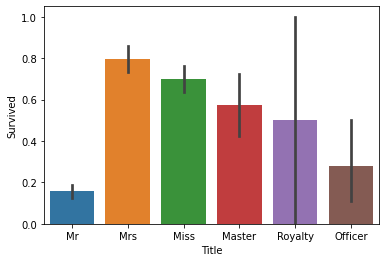

In [46]:
# Evidence that survival probability differs with title
train_withName = ohe_names(train)
sns.barplot(x='Title', y='Survived', data=train_withName);

In [47]:
# Cabin letters may be some indication, so we extract first letter
def add_cabin(df):
    """
    Add feature denoting Cabins A-G, T
    - Use "U" to denote Unknown cabin
    
    Use ordinal encoding to take advantage of the order of cabins
    
    Return cleaned dataframe
    """
    cleaned = df.copy()   
    cleaned['Cabin'] = cleaned['Cabin'].str[0]
    cleaned['Cabin'] = cleaned['Cabin'].fillna("U")
    
    cabin_map = {'T': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 
                 'E': 5, 'F': 6, 'G': 7, 'U': 8}
    
    cleaned['Cabin'] = cleaned['Cabin'].map(cabin_map)
    
    return cleaned

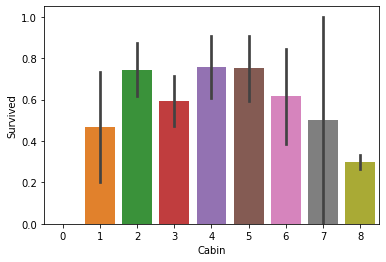

In [48]:
# Evidence that survival probability differs with Cabin
train_withCabin = add_cabin(train)
sns.barplot(x='Cabin', y='Survived', data=train_withCabin);

In [49]:
def add_alone(df):
    """
    Researched that passengers who traveled alone were less likely to survive
    Create binary variable that denotes "Alone"
    """
    cleaned = df.copy()
    cleaned['familySize'] = cleaned['SibSp'] + cleaned['Parch']
    # Alone Column - no sibsp and no parch
    cleaned['Alone'] = [1 if x == 0 else 0 for x in cleaned['familySize']]
    
    return cleaned

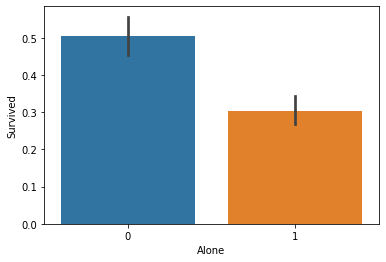

In [50]:
# Evidence that survival probability differs by Alone
train_withAlone = add_alone(train)
sns.barplot(x='Alone', y='Survived', data=train_withAlone);

In [269]:
def age_groups(df):
    """
    Bin passengers into different age groups 
    """
    cleaned = df.copy()
    
    cleaned['AgeGroup'] = pd.cut(df['Age'], 6, labels = ["Children", "Adolescents", 
                            "Young Adults","Adults", "Seniors", "Elders"])
    
    return cleaned

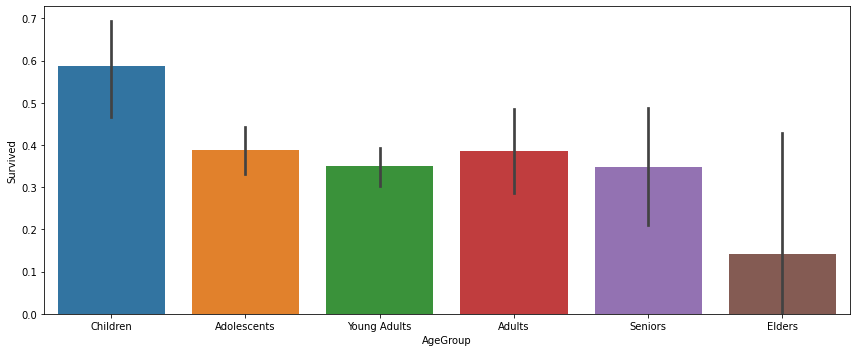

In [273]:
# Evidence that survival probability differs by Age group
train_withAge = replace_age(train)
train_withAge = age_groups(train_withAge)
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='AgeGroup', y='Survived', data=train_withAge, ax=ax);
fig.tight_layout()

In [274]:
def clean_ticket(df):
    """
    Separate tickets into pure digit vs non-digit prefix
    - replace all non-digit prefixes with digit if it occured less than 5 times to prevent overfitting
    """
    cleaned = df.copy()
    cleaned['Ticket'] = cleaned['Ticket'].str.replace('.','').str.replace('/','').str.split(' ').str[0].str.replace('^[0-9]+', 'Digit', regex=True)
    counts_above5 = cleaned['Ticket'].value_counts()[cleaned['Ticket'].value_counts() >= 5].index.values
    cleaned['Ticket'] = [x if x in counts_above5 else 'Digit' for x in cleaned['Ticket']]
    
    return cleaned

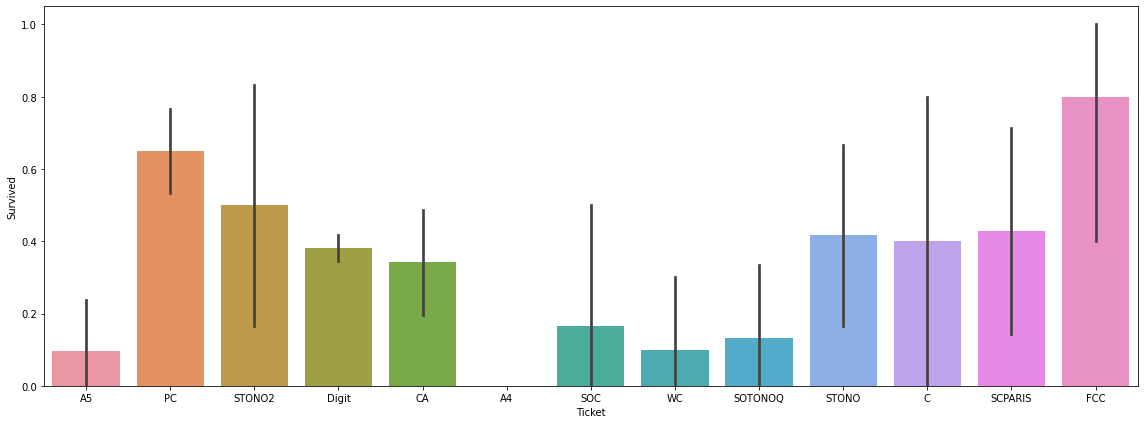

In [275]:
# Evidence that survival probability differs by Ticket group
train_withTicket = clean_ticket(train)
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='Ticket', y='Survived', data=train_withTicket, ax=ax);
fig.tight_layout()

### 2.3 Preprocessing

In [285]:
def preProcess(train, test):
    """
    Preprocess Raw Dataframe into design matrix (w/ response column)
    - concatenate train and test as joint dataframe to maximize signal in all data
    """
    y_train = train['Survived']
    train = train.drop(['Survived'], axis=1)
    train_ids = train['PassengerId']
    
    processed = pd.concat([train, test])
    processed = processed.reset_index()
    processed = processed.drop(['index'], axis=1)

    processed = replace_age(processed)
    processed = replace_fare(processed)
    # Fill embarked with majority class (only two NA)
    processed['Embarked'] = processed['Embarked'].fillna('S')
    
    # New Features
    processed = add_title(processed)
    processed = add_cabin(processed)
    processed = add_alone(processed)
    processed = clean_ticket(processed)
    processed = age_groups(processed)
    
    # OHE
    features = ['Embarked', 'Sex', 'Ticket', 'AgeGroup', 'Title']
    for feature in features:
        dummies = pd.get_dummies(processed[feature], prefix=feature, prefix_sep='_')
        processed = processed.join(dummies)
    
    # Scale Fare by family size to get cost per ticket
    processed['Fare_per_person'] = processed['Fare'] / (processed['familySize'] + 1)
    
    # Drop Unecessary columns
    # Drop Ticket to avoid overfitting
    processed = processed.drop(['Ticket', 'Name', 'Title', 
                                'Embarked', 'Sex', 'AgeGroup'], axis=1)
        
    # Standardize Continuous Features
    standard_scaler = StandardScaler()
    numerical_features = ['SibSp', 'Parch', 'Fare', 'Fare_per_person', 'Age', 
                          'Cabin', 'Pclass', 'familySize']
    processed[numerical_features] = standard_scaler.fit_transform(
                                            processed[numerical_features])
    
    
    """
    Separate back into train and test
    """
    train_df = processed[processed['PassengerId'].isin(train_ids)]
    train_df = train_df.drop(['PassengerId'], axis=1)
    train_df['Survived'] = y_train
    
    test_df = processed[~processed['PassengerId'].isin(train_ids)]
    test_df = test_df.drop(['PassengerId'], axis=1)
    
    return train_df, test_df

In [286]:
trainClean, testClean = preProcess(train, test)
trainClean.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,familySize,Alone,Embarked_C,Embarked_Q,...,AgeGroup_Seniors,AgeGroup_Elders,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Fare_per_person,Survived
0,0.841916,-0.564835,0.481288,-0.445,-0.503176,0.509153,0.073352,0,0,0,...,0,0,0,0,1,0,0,0,-0.472289,0
1,-1.546098,0.651087,0.481288,-0.445,0.734809,-1.912654,0.073352,0,1,0,...,0,0,0,0,0,1,0,0,0.423315,1
2,0.841916,-0.260855,-0.479087,-0.445,-0.490126,0.509153,-0.558346,1,0,0,...,0,0,0,1,0,0,0,0,-0.352005,1
3,-1.546098,0.423101,0.481288,-0.445,0.383263,-1.912654,0.073352,0,0,0,...,0,0,0,0,0,1,0,0,0.168994,1
4,0.841916,0.423101,-0.479087,-0.445,-0.487709,0.509153,-0.558346,1,0,0,...,0,0,0,0,1,0,0,0,-0.348508,0


In [287]:
print(f'Features: {trainClean.columns.values}')

Features: ['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'Cabin' 'familySize' 'Alone'
 'Embarked_C' 'Embarked_Q' 'Embarked_S' 'Sex_female' 'Sex_male'
 'Ticket_A4' 'Ticket_A5' 'Ticket_C' 'Ticket_CA' 'Ticket_Digit'
 'Ticket_FCC' 'Ticket_PC' 'Ticket_SCAH' 'Ticket_SCPARIS' 'Ticket_SCParis'
 'Ticket_SOC' 'Ticket_SOPP' 'Ticket_SOTONOQ' 'Ticket_STONO'
 'Ticket_STONO2' 'Ticket_WC' 'AgeGroup_Children' 'AgeGroup_Adolescents'
 'AgeGroup_Young Adults' 'AgeGroup_Adults' 'AgeGroup_Seniors'
 'AgeGroup_Elders' 'Title_Master' 'Title_Miss' 'Title_Mr' 'Title_Mrs'
 'Title_Officer' 'Title_Royalty' 'Fare_per_person' 'Survived']


## 3. Modeling

Because the training data contains only 891 rows, I decided to avoid more complex models, such as neural networks. Without extensive tuning, they would be very prone to overfitting on a small dataset. Simpler models, such as Logistic Regression, Random Forest, and K Nearest Neighbor models can be more easily optimized, and are less prone to overfitting.

In [288]:
Y_train = trainClean['Survived']
X_train = trainClean.drop(['Survived'], axis=1)

In [289]:
def cross_val_acc(model, X_train, Y_train, k):
    '''
    Compute k-fold Cross Validation accuracy

    Inputs:
        model: an sklearn model with fit and predict functions 
        X_train: Design Matrix
        Y_train: Response Vector
    Outputs:
        the average validation MSE for the k splits.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    validation_accuracies = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit model
        model.fit(split_X_train, split_Y_train)
        
        # Compute Accuracy on the validation split
        acc = model.score(split_X_valid, split_Y_valid)
        validation_accuracies.append(acc)
        
    return np.mean(validation_accuracies)

In [290]:
# Initialize
K = 5
RANDOM_STATE = 42

### 3.1 Logistic Regression

Investigate Baseline Model without Tuning

In [291]:
logreg = LogisticRegression(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(logreg, X_train, Y_train, K)
print(f'Logistic Regression {K} Fold CV Accuracy = {cv_acc}')

logreg.fit(X_train, Y_train)
print(f'Logistic Regression Training Accuracy = {logreg.score(X_train, Y_train)}')

Logistic Regression 5 Fold CV Accuracy = 0.8148201619484026
Logistic Regression Training Accuracy = 0.8316498316498316


### 3.2 Random Forest

In [292]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(rf, X_train, Y_train, K)
print(f'Random Forest {K} Fold CV Accuracy = {cv_acc}')

rf.fit(X_train, Y_train)
print(f'Random Forest Training Accuracy = {rf.score(X_train, Y_train)}')

Random Forest 5 Fold CV Accuracy = 0.8260372857949909
Random Forest Training Accuracy = 0.9865319865319865


### 3.3 K Nearest Neighbors

In [293]:
knn = KNeighborsClassifier(n_neighbors=5)
cv_acc = cross_val_acc(knn, X_train, Y_train, K)
print(f'K-Nearest Neighbors {K} Fold CV Accuracy = {cv_acc}')

knn.fit(X_train, Y_train)
print(f'K-Nearest Neighbors Training Accuracy = {knn.score(X_train, Y_train)}')

K-Nearest Neighbors 5 Fold CV Accuracy = 0.815931203314293
K-Nearest Neighbors Training Accuracy = 0.8630751964085297


### 3.4 Support Vector Classifier

In [294]:
svc = SVC(random_state=RANDOM_STATE)

cv_acc = cross_val_acc(svc, X_train, Y_train, K)
print(f'Support Vector Classifier {K} Fold CV Accuracy = {cv_acc}')

svc.fit(X_train, Y_train)
print(f'Support Vector Classifier Training Accuracy = {svc.score(X_train, Y_train)}')

Support Vector Classifier 5 Fold CV Accuracy = 0.8282907538760906
Support Vector Classifier Training Accuracy = 0.8406285072951739


### 3.5 Quadratic Discriminant Analysis

- Applied QDA to the top 10 PCs

In [340]:
pca = PCA(n_components=14, svd_solver='full')
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_))


pca_train = pd.DataFrame(pca.fit_transform(X_train))
qda = QuadraticDiscriminantAnalysis()
cv_acc = cross_val_acc(qda, pca_train, Y_train, K)
print(f'Quadratic Discriminant Analaysis {K} Fold CV Accuracy = {cv_acc}')

qda.fit(pca_train, Y_train)
print(f'Quadratic Discriminant Analaysis Training Accuracy = {qda.score(pca_train, Y_train)}')

0.9646427018365922
Quadratic Discriminant Analaysis 5 Fold CV Accuracy = 0.8091645220011298
Quadratic Discriminant Analaysis Training Accuracy = 0.8282828282828283


### 3.6 Hyperparameter Tuning

There is overfitting in all cases with the baseline models, so we will perform hyperparameter tuning

In [296]:
def gridSearch(pipe, param_grid, X_train, Y_train, K):
    """
    Returns best hyperparameters for a particular model based on training data
    """
    # Create grid search object
    clf = GridSearchCV(pipe, param_grid=param_grid, cv=K, 
                       scoring='accuracy', verbose=True, n_jobs=-1)
    # Fit on data
    best_model = clf.fit(X_train, Y_train)
    
    return best_model

In [297]:
# Find Best Logistic Regression
pipe = Pipeline([('classifier' , LogisticRegression(random_state=RANDOM_STATE, 
                                                    max_iter=1500))])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression(random_state=RANDOM_STATE, max_iter=1500)],
     'classifier__penalty' : ['l1', 'l2', 'elasticnet'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['saga']}
]

# Fit on data
best_logreg = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   39.3s finished


In [298]:
best_logreg.best_estimator_.get_params()['classifier']

LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [299]:
def display_results(model, name):
    """
    Show confusion matrix for model with tuned hyperparameters
    """
    # Confusion Matrix for Logistic Regression on Training Data
    print(f'Best {name} Accuracy = ', model.best_score_)
    ## Have more False Positives that False Negatives
    y_pred = model.predict(X_train)
    sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
    plt.ylabel('Actual');
    plt.xlabel('Predicted');
    plt.title(f'{name} Confusion Matrix on Training Data')

Best Logistic Regression Accuracy =  0.819295712761283


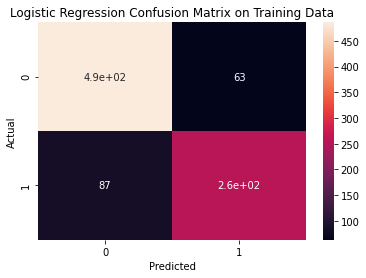

In [300]:
display_results(best_logreg, "Logistic Regression")

In [301]:
# Find Best Random Forest
pipe = Pipeline([('classifier' , RandomForestClassifier(random_state=RANDOM_STATE))])

num_features = len(X_train.columns.values)

# Create param grid.
param_grid = [
    {'classifier' : [RandomForestClassifier(random_state=RANDOM_STATE)],
    'classifier__n_estimators' : np.arange(100, 201, 10),
    'classifier__max_features' : np.linspace(0.2, 1, 5),
    'classifier__max_depth' : np.arange(7, 12),
    'classifier__min_samples_leaf' : np.arange(1, 3),
    'classifier__oob_score' : [True, False]}
]

# Fit on data
best_rf = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 5500 out of 5500 | elapsed: 19.5min finished


In [302]:
best_rf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features=0.8,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

Best Random Forest Accuracy =  0.8406126420187057


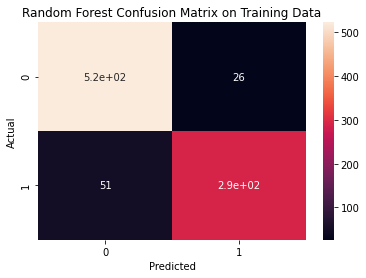

In [303]:
display_results(best_rf, "Random Forest")

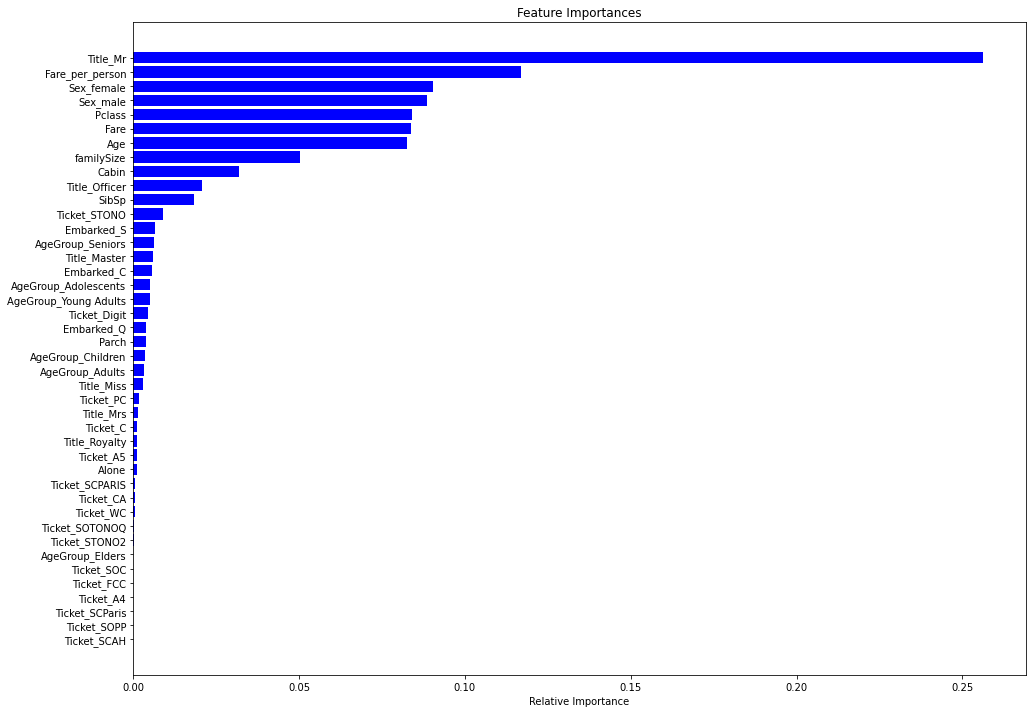

In [304]:
# Analyze Feature Importances
random_forest = best_rf.best_estimator_.get_params()['classifier']
features = X_train.columns.values
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [305]:
# Find Best KNN
pipe = Pipeline([('classifier' , KNeighborsClassifier())])

# Create param grid.
param_grid = [
    {'classifier' : [KNeighborsClassifier()],
    'classifier__n_neighbors' : np.arange(3, 50, 2),
    'classifier__weights' : ['uniform', 'distance'],
    'classifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__leaf_size' : np.arange(10, 51, 10)}
]

# Fit on data
best_knn = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 1400 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 3400 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   39.9s finished


In [306]:
best_knn.best_estimator_.get_params()['classifier']

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Best K Nearest Neighbors Accuracy =  0.8226602222082733


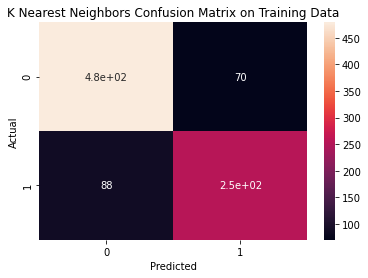

In [307]:
display_results(best_knn, "K Nearest Neighbors")

In [308]:
# Find Best Support Vector Machine Regression
pipe = Pipeline([('classifier' , SVC(random_state=RANDOM_STATE, 
                                                    max_iter=1500))])

# Create param grid.
param_grid = [{
    'classifier' : [SVC(random_state=RANDOM_STATE, max_iter=1500)],
    'classifier__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__gamma' : ['scale', 'auto'],
    'classifier__class_weight' : ['balanced', None]
}]

# Fit on data
best_svc = gridSearch(pipe, param_grid, X_train, Y_train, K)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1344 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:   27.5s finished


In [309]:
best_svc.best_estimator_.get_params()['classifier']

SVC(C=4.281332398719396, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
    kernel='rbf', max_iter=1500, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

Best Support Vector Classifier Accuracy =  0.838359173937606


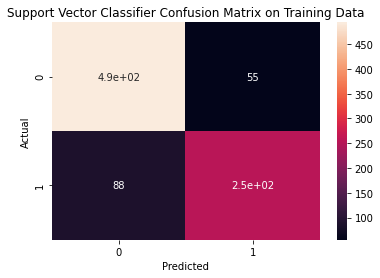

In [310]:
display_results(best_svc, "Support Vector Classifier")

In [341]:
# Find Best Support Vector Machine Regression
pipe = Pipeline([('classifier' , QuadraticDiscriminantAnalysis())])

# Create param grid.
param_grid = [{
    'classifier' : [QuadraticDiscriminantAnalysis()],
    'classifier__reg_param' : np.arange(0, 0.91, 0.1),
    'classifier__tol' : np.linspace(0.0001, 0.01, 100)
}]

# Fit on data
best_qda = gridSearch(pipe, param_grid, pca_train, Y_train, K)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 4492 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4993 out of 5000 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   11.6s finished


In [342]:
best_qda.best_estimator_.get_params()['classifier']

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.1,
                              store_covariance=False, tol=0.0001)

Best Quadratic Discriminant Analysis Accuracy =  0.8103069487163392


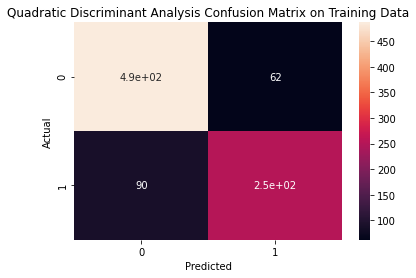

In [346]:
# Confusion Matrix for Logistic Regression on Training Data
print(f'Best Quadratic Discriminant Analysis Accuracy = ', best_qda.best_score_)
## Have more False Positives that False Negatives
y_pred = best_qda.predict(pca_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Actual');
plt.xlabel('Predicted');
plt.title('Quadratic Discriminant Analysis Confusion Matrix on Training Data');

## 4. Final Model Diagnostics and Predictions

All 3 models have a few more false positives, but splits are slightly different. Will Use voting classifier to utilize all 3 models.

In [347]:
lr = best_logreg.best_estimator_.get_params()['classifier']
rf = best_rf.best_estimator_.get_params()['classifier']
knn = best_knn.best_estimator_.get_params()['classifier']
svc = best_svc.best_estimator_.get_params()['classifier']
qda = best_qda.best_estimator_.get_params()['classifier']

eclf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), 
                                    ('knn', knn), ('svc', svc)], 
                        voting='hard')

In [348]:
cv_acc = cross_val_acc(eclf, X_train, Y_train, K)
print(f'Voting Model {K} Fold CV Accuracy = {cv_acc}')

eclf = eclf.fit(X_train, Y_train)
print(f'Voting Model Training Accuracy = {eclf.score(X_train, Y_train)}')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:228: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Voting Model 5 Fold CV Accuracy = 0.8271608813006089
Voting Model Training Accuracy = 0.8417508417508418


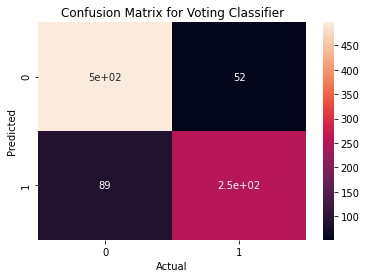

In [349]:
# Confusion Matrix for Voting model on Training Data
## Have more False Positives that False Negatives
y_pred = eclf.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Predicted');
plt.xlabel('Actual');
plt.title('Confusion Matrix for Voting Classifier');

In [350]:
# Make Final Predictions
test_preds = eclf.predict(testClean)
submission = pd.DataFrame({'PassengerId': test['PassengerId'],
                          'Survived': test_preds})
submission.to_csv('data/submission.csv', index=False)

**Final Results**

78.229% Accuracy on Kaggle Public Leaderboard

# Bonus Work

## Naive Bayes

- Tried, but didn't work, likely due to large amount of binary variables

Best Naive Bayes Accuracy =  0.468013468013468


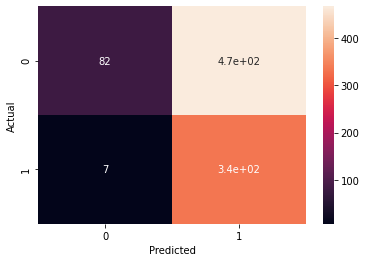

In [311]:
# Confusion Matrix for Naive Bayes Training Data
## No tuning to do - difficult to set priors

print('Best Naive Bayes Accuracy = ', gnb.score(X_train, Y_train))
## Have more False Positives that False Negatives
y_pred = gnb.predict(X_train)
sns.heatmap(confusion_matrix(Y_train, y_pred), annot=True);
plt.ylabel('Actual');
plt.xlabel('Predicted');